# Introduction to Survey Simulations

The goal of this notebook is to introduce you to the outputs available from DESI "survey simulations". These are the fastest type of DESI simulation to run and only involve the following components:
 - Simulated stochastic weather (seeing, transparency, ...). See [DESI-3087](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3087) for details.
 - Afternoon planning, which updates tile observing priorities and schedules fiber assignment.
 - Next tile selector, which determines which tile to observe next, based on recent progress and current weather.
 
The software for these components is mostly in the [desisurvey](https://desisurvey.readthedocs.io) and [surveysim](https://surveysim.readthedocs.io) packages.  Note that survey simulations operate at the level of tiles, not targets, and never generate spectra or redshifts and do not refer to any input catalog.  For a recent overview of the different DESI simluation types, see [DESI-3377](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3377).

This tutorial focuses on the using the outputs of a survey simulation. After working with the outputs from some existing simulations, you might want to run your own survey simulations: that tutorial is [here](http://surveysim.readthedocs.io/en/latest/tutorial.html).  For other tutorials, covering topics such as simulating your own DESI spectra, see [this list](https://github.com/desihub/tutorials/blob/master/README.md).

For general questions and suggestions on this tutorial, email desi-data@desi.lbl.gov. For more specific suggestions or bug reports, please [create a github issue](https://github.com/desihub/tutorials/issues).

## Getting Started

This notebook is optimized for use with the jupyter-dev service at NERSC, which provides pre-installed DESI software running in a jupyter notebook. If this is your first time using jupyter-dev at NERSC, follow [these instructions](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) to get it configured.

If you prefer to work on your laptop, you will need to [install the necessary DESI software locally](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop).

**If you are working through this notebook in a live jupyter session, I recommend removing all the output below for a more interactive experience.** Use the "Cell > Current Outputs > Clear" menu item.

**There are several exercises below for you to work on once you master the basics.**

#### DESI Version Compatibility

- 2017-12-04 : tested using the `DESI master` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs.
- 2018-03-30 : tested using the `DESI 18.3` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs (which were generated with an earlier version of the code).
- 2018-07-20 : tested using the `DESI 18.6` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs (which were generated with an earlier version of the code).
- 2018-10-15 : tested using the `DESI 18.7` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs (which were generated with an earlier version of the code).
- 2019-03-22 : tested using the `DESI 18.11` kernel.  It currently does *not* work with the
`18.12` or `19.2` kernels.
- 2019-07-01 : updated to use the `DESI 19.2` kernel.

### Load Modules

Import numpy and matplotlib and draw plots directly to the notebook:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import the `desisurvey` modules we need below:

In [2]:
import desisurvey.utils
import desisurvey.plots
from astropy.io import fits
import numpy
import desimodel
import surveysim.stats

Ignore expected harmless warnings (or don't run these lines if you prefer to see them):

In [3]:
import warnings, matplotlib.cbook, astropy._erfa.core
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings('ignore', category=astropy._erfa.core.ErfaWarning)

### Find Simulation Outputs

Identify which survey simulation you want to study by setting the `$DESISURVEY_OUTPUT` environment variable.

Here we look at the first of one hundred different realizations of the baseline survey as part of the surveysim 2018 data challenge.

Note that `$DESISURVEY_OUTPUT` is only read the first time you use a `desisurvey` function, so the easiest way to make a change below take effect is to restart the jupyter kernel and re-run the initial cells.

In [4]:
import os
os.environ['DESISURVEY_OUTPUT'] = '/global/projecta/projectdirs/desi/datachallenge/surveysim2018/weather/000'

## Survey Simulation Outputs

The outputs from a survey simulation are two FITS files, one organized by **tile** and the other organized by **exposure**.  Tiles are predefined ([DESI-717](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=717)) to cover the whole survey footprint in 8 dithered passes. Each tile is observed with one or more exposures.  Multiple exposures of a tile are sometimes required to:
 - Split a long exposure to minimize the impact of cosmic rays.
 - Continue an exposure that is terminated early due to a program change (or dawn).
 - Continue an exposure that is found to have insufficient signal to noise after pipeline processing.

After setting `$DESISURVEY_OUTPUT`, look at the corresponding files using:

In [5]:
os.listdir(os.environ['DESISURVEY_OUTPUT'])

['exposures.fits',
 'stats.fits',
 'ephem_2019-01-01_2025-12-31.fits',
 'surveyinit.fits']

The `ephem` and `surveyinit` files contain the ephemerides for the DESI survey duration and the initial LST assignments, and will not be considered further here.

In [6]:
exposures = fits.getdata(os.path.join(os.environ['DESISURVEY_OUTPUT'], 'exposures.fits'), 'exposures')
tiles = fits.getdata(os.path.join(os.environ['DESISURVEY_OUTPUT'], 'exposures.fits'), 'tiledata')

In [7]:
print('Survey runs {} to {} and observes {} tiles with {} exposures'
      .format(
          desisurvey.utils.get_date(numpy.min(exposures['mjd'])),
          desisurvey.utils.get_date(numpy.max(exposures['mjd'])), numpy.sum(tiles['snr2frac'] >= 1), len(exposures)))

Survey runs 2019-12-03 to 2024-11-19 and observes 15964 tiles with 41623 exposures


Note that progress uses MJD timestamps internally, which can be converted to dates using [`desisurvey.utils.get_date()`](http://desisurvey.readthedocs.io/en/latest/api.html?highlight=get_date#desisurvey.utils.get_date).

The exposures HDU has one record per exposure, and the tiles HDU has one record per tile.

In [8]:
print(repr(exposures[:3]))
print(repr(tiles[:3]))

FITS_rec([ ( 58821.06388889,  1040., 24346,  0.50391221,  1.00018501,  1.02858937,  0.97081822,  1.),
          ( 58821.07662037,   690., 24346,  0.87731832,  1.00018501,  1.27637327,  0.80424196,  1.),
          ( 58821.08599537,   710., 24084,  0.34194383,  1.00135243,  1.1137799 ,  0.8847155 ,  1.)],
         dtype=(numpy.record, [('MJD', '>f8'), ('EXPTIME', '>f4'), ('TILEID', '>i4'), ('SNR2FRAC', '>f4'), ('AIRMASS', '>f4'), ('SEEING', '>f4'), ('TRANSP', '>f4'), ('SKY', '>f4')]))
FITS_rec([(0, 0,  6530.,  1.00028896, 8), (0, 0,  1100.,  1.00405967, 2),
          (0, 0,  1520.,  1.0036422 , 2)],
         dtype=(numpy.record, [('AVAIL', '>i4'), ('PLANNED', '>i4'), ('EXPTIME', '>f4'), ('SNR2FRAC', '>f4'), ('NEXP', '>i4')]))


The exposures HDU tracks quantities like the MJDs on which the exposures were observed, the tiles which they observed, the conditions of those observations, and the accumulated SNR2 fraction.

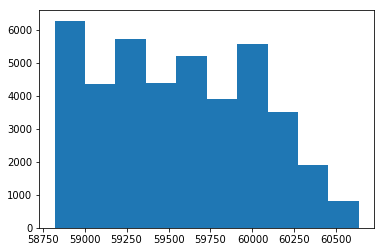

In [9]:
_ = plt.hist(exposures['mjd'])

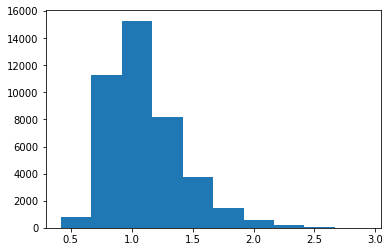

In [10]:
_ = plt.hist(exposures['seeing'])

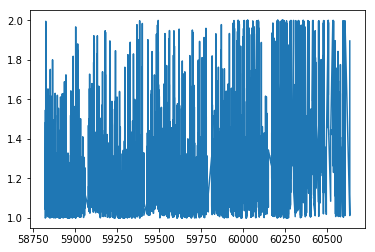

In [11]:
plt.plot(exposures['mjd'], exposures['airmass'])

In this strategy, later exposures tend to be observed at higher airmasses.

The tiles HDU does not replicate useful information already in the tile file.  Let's link in that information...

In [12]:
tiledat = desimodel.io.load_tiles()

The tiles HDU is row-matched to the tile file.

In [13]:
print(tiledat.shape, tiles.shape)

(16071,) (16071,)


The desisurvey.plots module contains routines to visualize survey parameters.  Here we show tile completeness in each of the 8 passes (4 dark, one gray, three bright).  All passes except the final bright pass were completed.  There is a slight tendency for tiles at low and high decs and at the edge of the footprint to take longer than other tiles, due to airmass and Galactic extinction, but weather effects dominate.

(<matplotlib.figure.Figure at 0x2aaaea3a8f60>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaea3a8cc0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaea56a710>]], dtype=object))

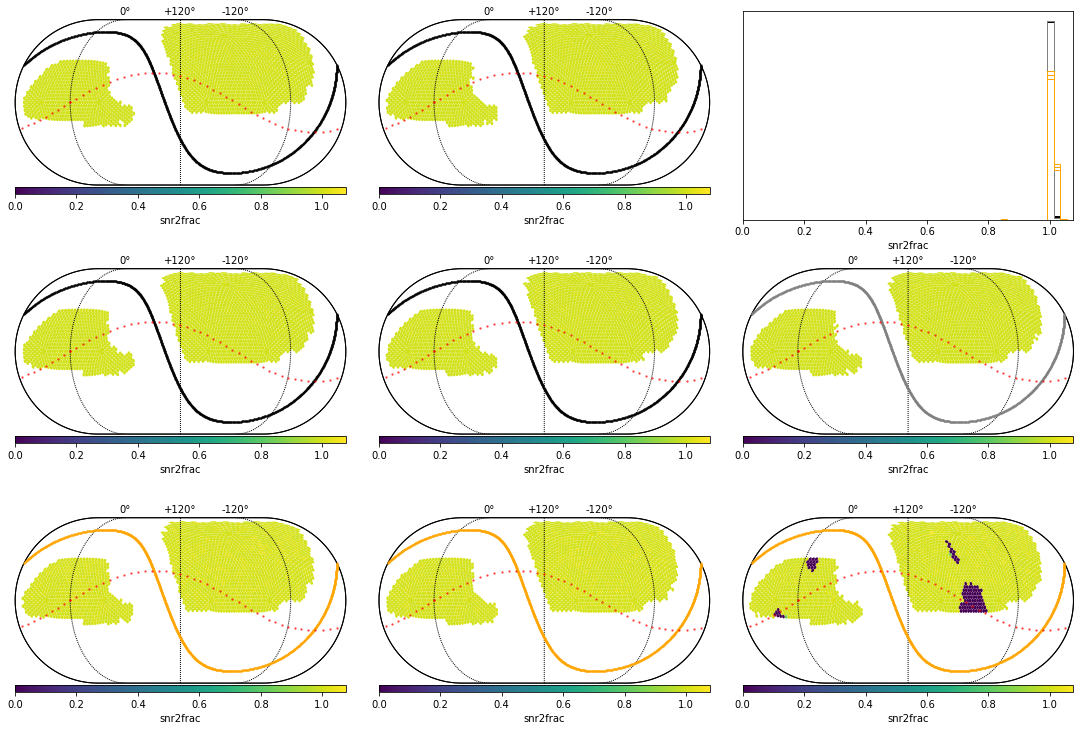

In [14]:
desisurvey.plots.plot_sky_passes(tiledat['ra'], tiledat['dec'], tiledat['pass'], tiles['snr2frac'], label='snr2frac')

(<matplotlib.figure.Figure at 0x2aaaea3576a0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaf2e48ef0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaf3538a90>]], dtype=object))

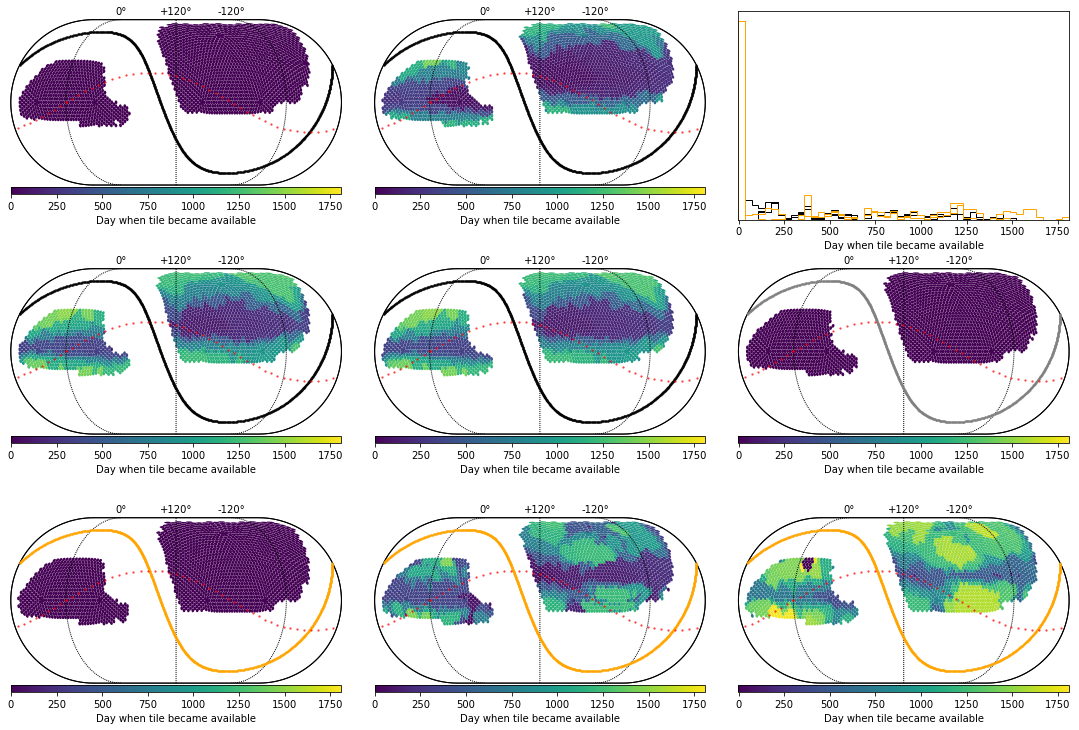

In [15]:
desisurvey.plots.plot_sky_passes(tiledat['ra'], tiledat['dec'], tiledat['pass'], tiles['avail'], label='Day when tile became available')

Now let's look at the efficiency of the survey over time.  The statistics file tracks survey statistics on each **night** of observations.

In [16]:
stats = surveysim.stats.SurveyStatistics(restore=os.path.join(os.environ['DESISURVEY_OUTPUT'], 'stats.fits'))

INFO:stats.py:75:__init__: Restored stats from /global/projecta/projectdirs/desi/datachallenge/surveysim2018/weather/000/stats.fits
INFO:stats.py:77:__init__:   Comment: "".


(<matplotlib.figure.Figure at 0x2aaaea351b38>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaafe9e6978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaff0b1dd8>], dtype=object))

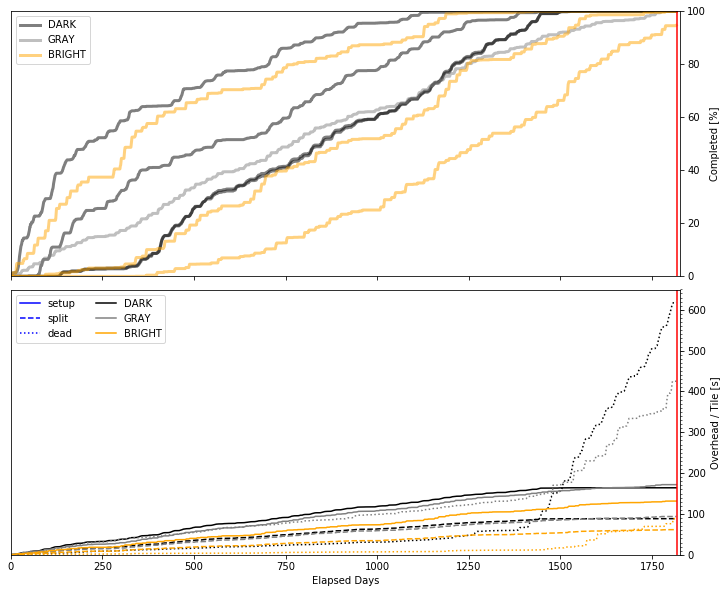

In [17]:
stats.plot()

The `summarize` method gives a text summary of the survey completeness and efficiency.

In [20]:
stats.summarize()

Scheduled 12788.664 hr Open 74.361% Live 69.874%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   0 2010/2010  5803  2755   3  3048   3 1936.9s 164.6s  91.0s
DARK   1 2011/2011  5627  2722   1  2905   2 1888.1s 162.4s  86.7s
DARK   2 2007/2007  5638  2722   4  2916   2 1880.7s 162.8s  87.2s
DARK   3 2010/2010  5766  2788   5  2978   1 1911.4s 166.6s  88.9s
DARK     8038/8038 22834 10987  13 11847   8 1904.3s 164.1s  88.5s 2793.5s 636.7s
----------------------------------------------------------------------------------
GRAY   4 2005/2005  6001  2869   4  3132   2 2109.1s 171.8s  93.7s
GRAY     2005/2005  6001  2869   4  3132   2 2109.1s 171.8s  93.7s 2831.7s 457.1s
----------------------------------------------------------------------------------
BRIGHT 5 2007/2007  4356  2243   0  2113   3  733.0s 134.1s  63.2s
BRIGHT 6 2011/2011  4349  2255   2  2094   3  738.8s 134.7s  62.5s
BRIGHT 7 1903/2010  4083  2107   6  1976   2  751.0s 133.1s  62.3s
BRI

The survey was completed in all passes except for the last bright pass, of which 1903 of 2010 passes were completed, in this simulation.  Only a small number of exposures were aborted.  An average of 10 minutes a night was lost to dead time in dark time, mostly at the end of the survey when tiles are not available at all LSTs.

## Tiles Summary

The tiles table has one row per tile containing summary statistics of all exposures (if any) of that tile:

In [21]:
tiles[:3]

FITS_rec([(0, 0,  6530.,  1.00028896, 8), (0, 0,  1100.,  1.00405967, 2),
          (0, 0,  1520.,  1.0036422 , 2)],
         dtype=(numpy.record, [('AVAIL', '>i4'), ('PLANNED', '>i4'), ('EXPTIME', '>f4'), ('SNR2FRAC', '>f4'), ('NEXP', '>i4')]))

The primary metric used to set the goal total exposure time for each tile is signal-to-noise ratio (SNR) for a set of predefined "threshold targets":
 - DARK & GRAY programs: ELGs with integrated \[OII\] flux of 8e-17 erg/(s cm^2)
 - BRIGHT program: BGS targets with r=19.5 and no emission lines
 
Plot the ratio of actual / goal SNR for each tile:

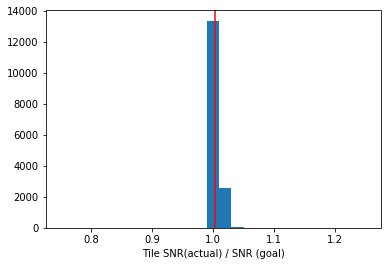

In [22]:
plt.hist(tiles['snr2frac'], range=(0.75, 1.25), bins=25)
plt.xlabel('Tile SNR(actual) / SNR (goal)')
plt.axvline(np.median(tiles['snr2frac']), c='r');

Plot the corresponding total exposure times, which shows two peaks for the BRIGHT and DARK+GRAY programs:

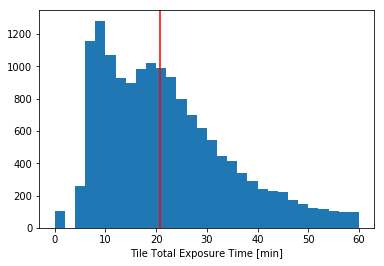

In [23]:
plt.hist(tiles['exptime'] / 60, range=(0, 60), bins=30)
plt.xlabel('Tile Total Exposure Time [min]')
plt.axvline(np.median(tiles['exptime'] / 60), c='r');

To plot the distribution of any column's values over the sky, separately for each of the 8 passes, use `plot_sky_passes`:

In [24]:
help(desisurvey.plots.plot_sky_passes)

Help on function plot_sky_passes in module desisurvey.plots:

plot_sky_passes(ra, dec, passnum, z, clip_lo=None, clip_hi=None, label='label', cmap='viridis', save=None)
    Plot sky maps for each pass of a per-tile scalar quantity.
    
    The matplotlib and basemap packages must be installed to use this function.
    
    Parameters
    ----------
    ra : array
        Array of RA values to use in degrees.
    dec : array
        Array of DEC values to use in degrees.
    pass : array
        Array of integer pass values to use.
    z : array
        Array of per-tile values to plot.
    clip_lo : float or string or None
        See :meth:`desiutil.plot.prepare_data`
    clip_hi : float or string or None
        See :meth:`desiutil.plot.prepare_data`
    label : string
        Brief description of per-tile value ``z`` to use for axis labels.
    cmap : colormap name or object
        Matplotlib colormap to use for mapping data values to colors.
    save : string or None
        Name

For example, to see the distributions of SNR(actual) / SNR(goal) over the sky after year 1 (this function takes ~30s to run):

The following columns summarize the afternoon planning and scheduling of fiber assignment (FA):
 - covered: Date the tile is first covered by previous layers and thus eligible for FA.
 - available: Date the tile first has fibers assigned.
 - planned: Date the tile is first included in the observing plan.
 
All dates are specified as an integer number of days from the survey start date (defined by [this utility function](http://desisurvey.readthedocs.io/en/latest/api.html#desisurvey.utils.day_number)).  As an example, plot the number of days into the survey that each tile is covered:

Note that the depth-first strategy has all tiles planned (=0) at the start of the survey, but other strategies have more complex dependencies between different regions of the sky in each pass.

### Exercises

In [25]:
# Plot a histogram of the number of exposures of each tile in the full survey.

In [26]:
# Plot histograms of snr2frac after year-1 separately for the DARK, GRAY, BRIGHT programs.

In [27]:
# Create all-sky plots of the mean airmass that each tile was observed at in the full survey.

In [28]:
# Study the tile "overhead", defined as 86400 * (mjd_max - mjd_min) - exptime.

## Exposures List

The exposures list is a table with rows corresponding to each simulated exposure, in increasing time order, with columns for their simulated observing conditions. Note that column names are all UPPER CASE.

In [29]:
exposures[:3]

FITS_rec([ ( 58821.06388889,  1040., 24346,  0.50391221,  1.00018501,  1.02858937,  0.97081822,  1.),
          ( 58821.07662037,   690., 24346,  0.87731832,  1.00018501,  1.27637327,  0.80424196,  1.),
          ( 58821.08599537,   710., 24084,  0.34194383,  1.00135243,  1.1137799 ,  0.8847155 ,  1.)],
         dtype=(numpy.record, [('MJD', '>f8'), ('EXPTIME', '>f4'), ('TILEID', '>i4'), ('SNR2FRAC', '>f4'), ('AIRMASS', '>f4'), ('SEEING', '>f4'), ('TRANSP', '>f4'), ('SKY', '>f4')]))

To see the distribution of individual exposure times (and compare with the total exposure time plot above), use:

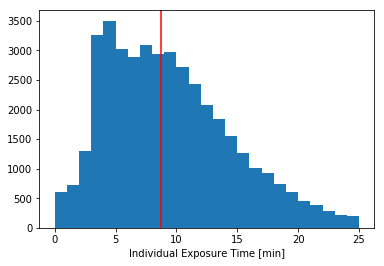

In [30]:
plt.hist(exposures['EXPTIME'] / 60, range=(0, 25), bins=25)
plt.xlabel('Individual Exposure Time [min]')
plt.axvline(np.median(exposures['EXPTIME'] / 60), c='r');

To see the distribution of atmospheric seeing during the simulated survey, use:

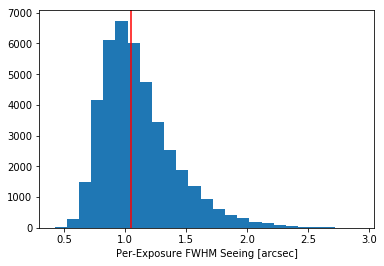

In [31]:
plt.hist(exposures['SEEING'], bins=25)
plt.xlabel('Per-Exposure FWHM Seeing [arcsec]')
plt.axvline(np.median(exposures['SEEING']), c='r');

To study the correlation between  exposure time and seeing in the first DARK pass, use:

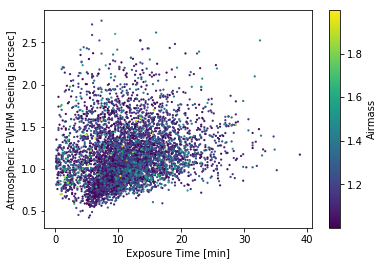

In [32]:
maxpass0 = numpy.max(tiledat['tileid'][tiledat['pass'] == 0])
pass1 = exposures[exposures['tileid'] <= maxpass0]
plt.scatter(pass1['EXPTIME'] / 60, pass1['SEEING'], c=pass1['AIRMASS'], lw=0, s=5);
plt.colorbar().set_label('Airmass')
plt.xlabel('Exposure Time [min]')
plt.ylabel('Atmospheric FWHM Seeing [arcsec]');

That describes the one particular realization of the survey.  Perhaps, however, we're interested in knowing how sensitive our completion fraction is to weather after the first year...

In [51]:
tilesob = desisurvey.tiles.Tiles()

def completed_in_timerange(exposures, startmjd, stopmjd):
    m = (exposures['mjd'] > startmjd) & (exposures['mjd'] < stopmjd)
    tilepass = tilesob.passnum[tilesob.index(exposures['tileid'])]
    return [numpy.sum(exposures['snr2frac'][m & (tilepass == pass0)] >= 1)
            for pass0 in tilesob.passes]

In [57]:
print('First day: {}'.format(int(numpy.min(exposures['mjd']))))

First day: 58821


In [60]:
completed = []

parentdir = '/global/projecta/projectdirs/desi/datachallenge/surveysim2018/weather'

for direc in range(100):
    exposures0 = fits.getdata(os.path.join(parentdir, '{:03}'.format(direc), 'exposures.fits'))
    completed.append(completed_in_timerange(exposures0, 58821, 58821+365))

In [75]:
print('pass, fraction complete, standard deviation')
for tpass, ttilecomplete, ttilestd in zip(tilesob.passes, numpy.mean(completed, axis=0), numpy.std(completed, axis=0)):
    ntile = tilesob.pass_ntiles[tpass]
    print('{} {:5.1%} {:5.1%}'.format(tpass, ttilecomplete/ntile, ttilestd/ntile))

pass, fraction complete, standard deviation
0 59.9%  2.6%
1 35.2%  2.9%
2  5.0%  1.0%
3  5.4%  1.0%
4 22.6%  1.7%
5 53.0%  4.0%
6  9.9%  1.7%
7  0.4%  0.2%


### Exercises

In [33]:
# Study the correlation between exposure time and moon altitude (which is underestimated in these simulations)

In [34]:
# Plot histograms of the number of exposures per night in each program.

In [35]:
# Study how often GRAY and BRIGHT exposures are taken with no moon in the sky.

In [36]:
# Study which of the 3 moon parameters correlates most strongly with exposure time.